In [1]:
import sys
sys.path.append("..")

import networkx as nx
import matplotlib.pyplot as plt
from src.graphgen.synthetic_graph_dataset_PyG import *
from torch_geometric.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [2]:
dataset = SyntheticGraphDatasetPyG('graphGenDataset1000.pkl')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')
print(f'Class label: ', data.y)
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges/2}') # divide by 2 because of undirected edges
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: SyntheticGraphDatasetPyG(1000):
Number of graphs: 1000
Number of features: 10

Data(x=[120, 10], edge_index=[2, 4318], y=[1])
Class label:  tensor([0])
Number of nodes: 120
Number of edges: 2159.0
Average node degree: 35.98
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/Users/kumarh/Documents/fall_co-op_2023/experiments/../src/graphgen/synthetic_graph_dataset_PyG.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/torch/csrc/utils/tensor_new.cpp:233.)
  edge_index = torch.tensor(graph_adj.nonzero(), dtype=torch.long)


nodes: 81
edges: 992
label: 0


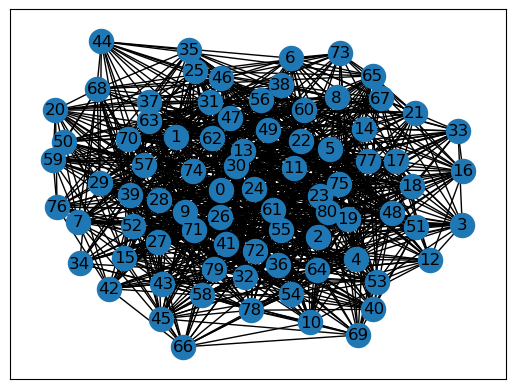

In [3]:
## verify the dataset

with open('graphGenDataset100.pkl', 'rb') as f:
    dd = pickle.load(f)

gg = nx.Graph(dd[0][0])
nx.draw_networkx(gg, pos=nx.spring_layout(gg))

print(f'nodes: {len(gg.nodes())}')
print(f'edges: {len(gg.edges())}')
print(f'label: {dd[0][3]}')


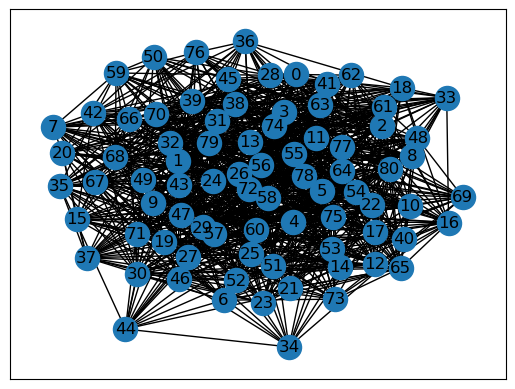

In [4]:
# Convert the PyTorch Geometric Data object to a NetworkX graph
graph = nx.Graph()
graph.add_nodes_from(range(data.num_nodes))
graph.add_edges_from(data.edge_index.t().tolist())

# Visualize the graph
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, pos=pos)
plt.show()

In [3]:
# Split the dataset into training and testing subsets
train_dataset = dataset[:int(0.8 * len(dataset))]
test_dataset = dataset[int(0.8 * len(dataset)):]

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
train_dataset.num_classes, train_dataset.num_features, train_dataset.num_node_features, train_dataset.print_summary(), train_loader.batch_size

SyntheticGraphDatasetPyG (#graphs=800):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    100.5 |   3050.7 |
| std        |     12.1 |    727.4 |
| min        |     80   |   1756   |
| quantile25 |     90   |   2437.5 |
| median     |    100   |   2998   |
| quantile75 |    112   |   3716.5 |
| max        |    120   |   4460   |
+------------+----------+----------+


(2, 10, 10, None, 64)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 101):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 002, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 003, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 004, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 005, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 006, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 007, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 008, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 009, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 010, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 011, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 012, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 013, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 014, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 015, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 016, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 017, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 018, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 019, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 020, Train Acc: 0.5212, Test Acc: 0.5200
Epoch: 021, Train Acc: 0.5212, Test Acc:

In [8]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

model = Net(dim=32).to(device)
print(model)

Net(
  (conv1): GraphConv(10, 32)
  (conv2): GraphConv(32, 32)
  (conv3): GraphConv(32, 32)
  (conv4): GraphConv(32, 32)
  (conv5): GraphConv(32, 32)
  (lin1): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.NLLLoss()

def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [10]:
for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 210451.0606, Train Acc: 0.4925, Test Acc: 0.5000
Epoch: 002, Loss: 40195.3882, Train Acc: 0.5075, Test Acc: 0.5200
Epoch: 003, Loss: 19719.2487, Train Acc: 0.5112, Test Acc: 0.4500
Epoch: 004, Loss: 8081.9427, Train Acc: 0.5025, Test Acc: 0.5100
Epoch: 005, Loss: 3124.7981, Train Acc: 0.5375, Test Acc: 0.4850
Epoch: 006, Loss: 1058.0360, Train Acc: 0.5300, Test Acc: 0.5200
Epoch: 007, Loss: 478.2966, Train Acc: 0.5288, Test Acc: 0.5200
Epoch: 008, Loss: 518.4744, Train Acc: 0.5262, Test Acc: 0.5150
Epoch: 009, Loss: 499.7596, Train Acc: 0.4875, Test Acc: 0.5150
Epoch: 010, Loss: 259.3220, Train Acc: 0.5250, Test Acc: 0.5100
Epoch: 011, Loss: 168.1083, Train Acc: 0.4863, Test Acc: 0.5050
Epoch: 012, Loss: 181.7400, Train Acc: 0.4975, Test Acc: 0.4850
Epoch: 013, Loss: 226.6825, Train Acc: 0.4875, Test Acc: 0.4900
Epoch: 014, Loss: 329.5581, Train Acc: 0.4850, Test Acc: 0.4800
Epoch: 015, Loss: 452.3681, Train Acc: 0.5288, Test Acc: 0.5150
Epoch: 016, Loss: 168.3921, Tr